# Making Predictions with ARIMA using historical data

In this notebook, I would be implementing a simple ARIMA model to predict kWHDelivered using three different methods:

1. Using historical data from only one charging station
2. Using historical data from 54 charging stations with cummulative electricity delivered (kWhDelivered)
3. Using historical data for each 54 charging stations using Transfer Learning

## Method 1: Making Predictions with ARIMA using historical data from only one charging station in JPL

In this first method, we would be making a prediction with ARIMA using only the historical charging station data for a single charging station

In [ ]:
# Import the required packages

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import os as os
from smape import smape

In [3]:
#Load the data from the local file

In [88]:
data = pd.read_csv('./jpl_model_data/1-1-178-817.csv')

In [15]:
# Display the first few rows of the dataframe

In [89]:
data.tail()

,month,siteID,stationID,timezone,spaceID,kWhDelivered,MinTemp,MaxTemp,AvgTemp,AvgPrecipitation,AvgHumidity,AvgWindSpeed
7,2019-04,1,1-1-178-817,America/Los_Angeles,AG-1F09,398.767000,11,29,17.733333,0.009167,50.929167,8.108333
8,2019-05,1,1-1-178-817,America/Los_Angeles,AG-1F09,527.571000,10,26,16.645161,0.050806,58.834677,8.802419
9,2019-06,1,1-1-178-817,America/Los_Angeles,AG-1F09,424.334000,14,36,21.633333,0.000833,56.312500,7.720833
10,2019-07,1,1-1-178-817,America/Los_Angeles,AG-1F09,537.814406,16,36,24.548387,0.000000,52.036290,7.241935
11,2019-08,1,1-1-178-817,America/Los_Angeles,AG-1F09,471.962000,17,34,25.483871,0.000000,49.379032,6.588710


In [175]:
# Convert the month to datetime format and set it as the index

In [90]:
data['Month'] = pd.to_datetime(data['month'])
data.set_index('Month', inplace=True)

In [26]:
# Prepare the data for ARIMA
# ARIMA requires univariate data, so we'll focus on the kwhDelivered series

In [91]:
kwh_series = data['kWhDelivered']
kwh_series.tail()

Month
2019-04-01    398.767000
2019-05-01    527.571000
2019-06-01    424.334000
2019-07-01    537.814406
2019-08-01    471.962000
Name: kWhDelivered, dtype: float64

In [29]:
# Split data into training and testing sets

In [92]:
train, test = kwh_series[:-1], kwh_series[-1:]

In [31]:
# Fit ARIMA model

In [93]:
# Ensure the index is a DatetimeIndex
train.index = pd.to_datetime(train.index)

# Set the frequency to monthly start ('MS')
train = train.asfreq('MS')


ARIMA_ORDER = (1, 1, 1)
model = ARIMA(train, order=ARIMA_ORDER)  # (p,d,q) order
model_fit = model.fit()

In [40]:
# Make predictions using the trained model

In [94]:
predictions = model_fit.forecast(steps=len(test))

In [38]:
# Evaluate the model using Mean Square Error, Mean Absolute Error and Symmetric Mean Absolute Percentage Error

In [95]:
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
smape_value = smape(test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Symmetric Mean Absolute Percentage Error: {round(smape_value,2)}%')


Mean Squared Error: 410.614081964376
Mean Absolute Error: 20.263614730950053
Symmetric Mean Absolute Percentage Error: 4.39%


In [219]:
# Plot the predictions vs actual values

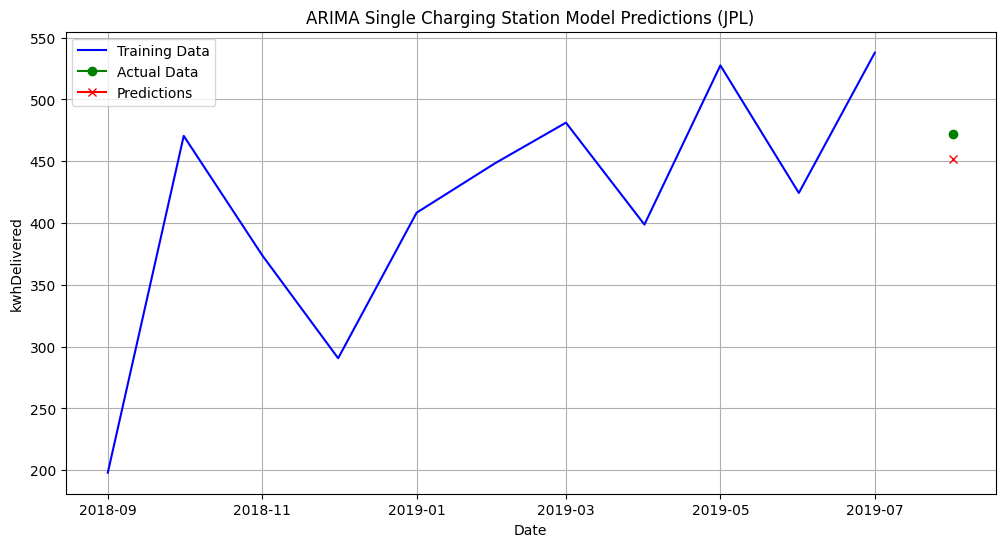

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='b')
plt.plot(test.index, test, label='Actual Data', marker="o", color='g')
plt.plot(test.index, predictions, label='Predictions',marker="x", color='r')
plt.title('ARIMA Single Charging Station Model Predictions (JPL)')
plt.xlabel('Date')
plt.ylabel('kwhDelivered')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Print summary of the model

In [22]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           kWhDelivered   No. Observations:                   11
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -59.997
Date:                Thu, 29 Aug 2024   AIC                            125.994
Time:                        15:44:15   BIC                            126.901
Sample:                    09-01-2018   HQIC                           124.998
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5278      0.390     -1.353      0.176      -1.293       0.237
ma.L1         -0.4468      0.534     -0.837      0.403      -1.493       0.600
sigma2      8544.6390   5853.735      1.460      0.1

## Method 2: Making Predictions with ARIMA using historical data from 54 charging stations with cummulative kWhDelivered

In [48]:
# Define the directory containing the CSV files

In [75]:
directory = './jpl_model_data'

In [ ]:
# Load data and sum all CSV files into a single dataframe

In [76]:
combined_data = pd.DataFrame()


# Loop through each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        # Load the data from the CSV file
        data = pd.read_csv(filepath)
        # Append the data to the combined DataFrame
        combined_data = pd.concat([combined_data, data], axis=0)

# Group by siteID and sum kWhDelivered
summed_data = combined_data.groupby('month')['kWhDelivered'].sum().reset_index()

# Print or save the result
summed_data

,month,kWhDelivered
0,2018-09,9514.851000
1,2018-10,18161.496291
2,2018-11,15311.232726
3,2018-12,14177.875000
4,2019-01,19698.515000
5,2019-02,18980.603000
6,2019-03,20874.830000
7,2019-04,22319.628000
8,2019-05,23115.409343
9,2019-06,20062.138920


In [ ]:
# Train the model

In [77]:
summed_kwh_series = summed_data['kWhDelivered']
summed_month = summed_data['month']

train, test = summed_kwh_series[:-1], summed_kwh_series[-1:]

In [289]:
#Fit ARIMA

In [78]:
model = ARIMA(train, order=ARIMA_ORDER)
model_fit = model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
## Making Predictions using the model

In [79]:
predictions = model_fit.forecast(steps=len(test))

In [ ]:
# Evaluate the model using Mean Square Error, Mean Absolute Error and Symmetric Mean Absolute Percentage Error

In [80]:
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
smape_value = smape(test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Symmetric Mean Absolute Percentage Error: {round(smape_value,2)}%')

Mean Squared Error: 3003169.277117701
Mean Absolute Error: 1732.9654575662207
Symmetric Mean Absolute Percentage Error: 7.75%


In [ ]:
# Plot the predictions vs actual values

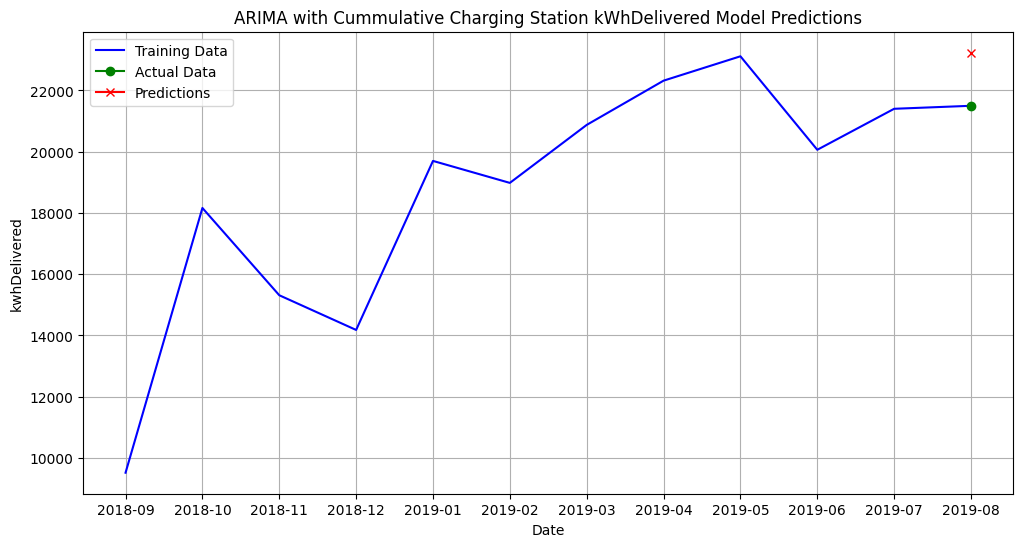

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(summed_month, summed_kwh_series, label='Training Data', color='b')
plt.plot(test.index, test, label='Actual Data',marker='o', color='g')
plt.plot(test.index, predictions, label='Predictions',marker='x', color='r')
plt.title('ARIMA with Cummulative Charging Station kWhDelivered Model Predictions')
plt.xlabel('Date')
plt.ylabel('kwhDelivered')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           kWhDelivered   No. Observations:                   11
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -95.771
Date:                Thu, 29 Aug 2024   AIC                            197.541
Time:                        16:12:17   BIC                            198.449
Sample:                             0   HQIC                           196.545
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6882      0.460     -1.495      0.135      -1.591       0.214
ma.L1          0.9998      0.922      1.084      0.278      -0.808       2.807
sigma2       1.11e+07   8.35e-08   1.33e+14      0.0

## Method 3: Making Predictions with ARIMA using historical data for each 54 charging stations using Transfer Learning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


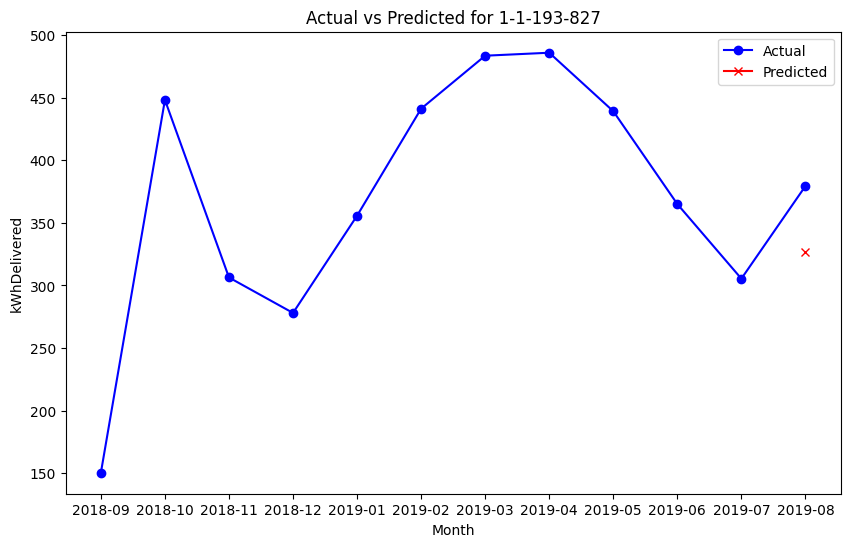

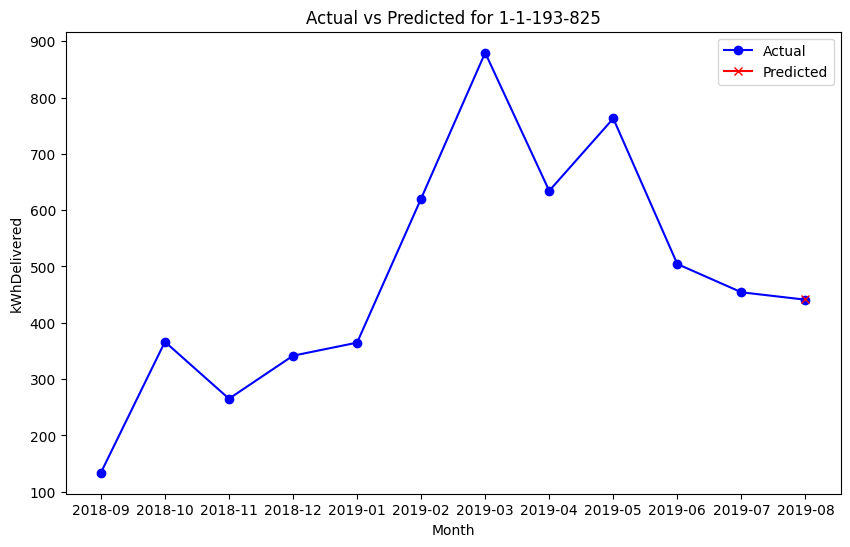

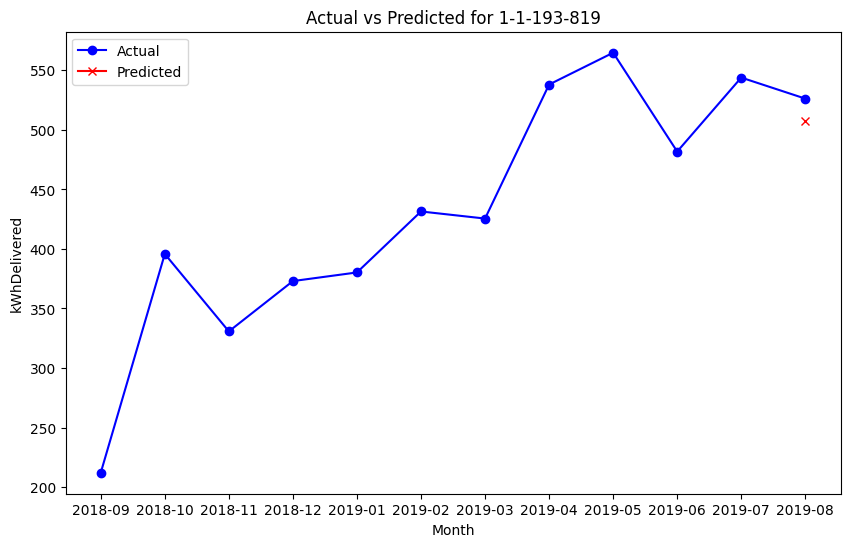

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


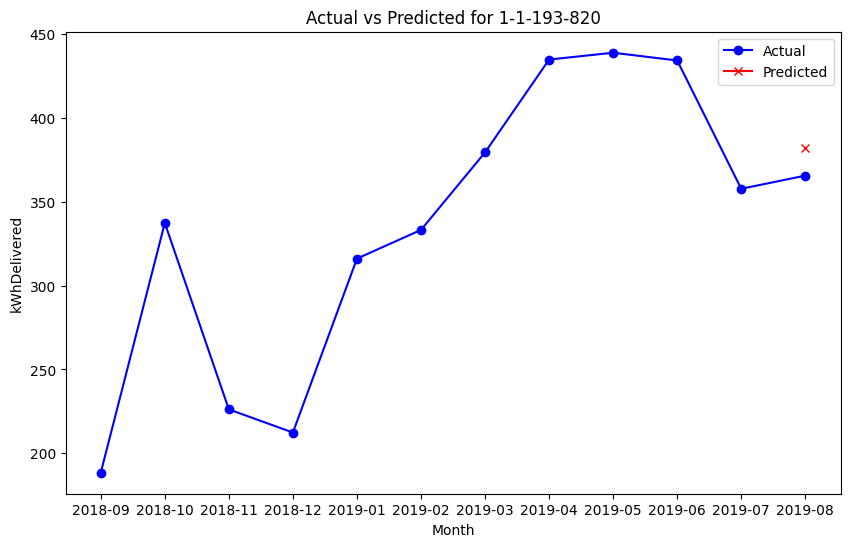

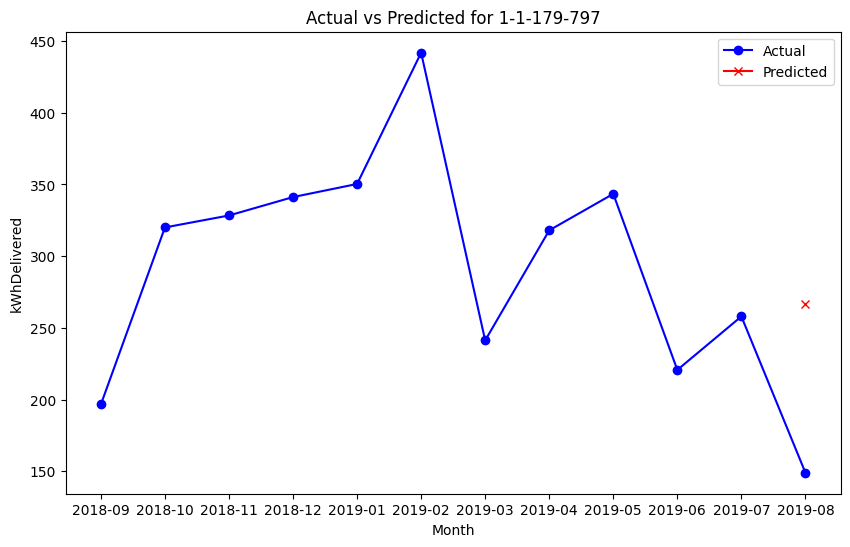

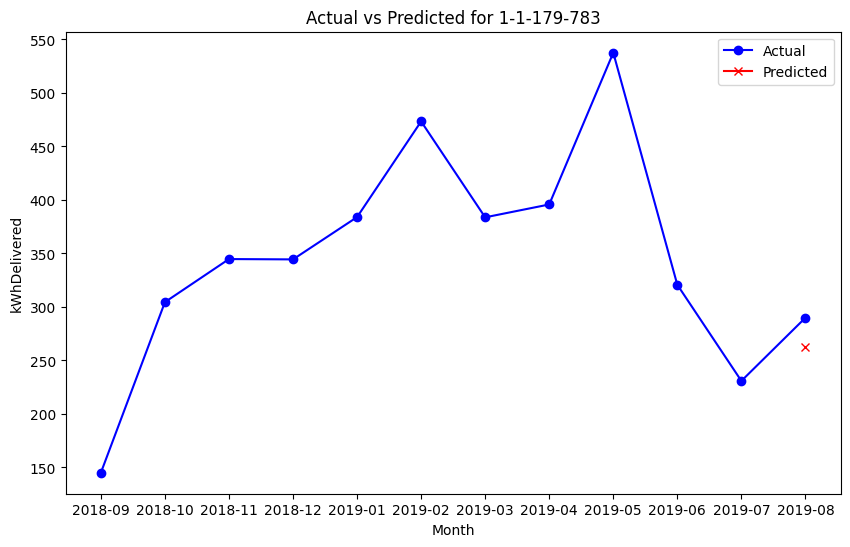

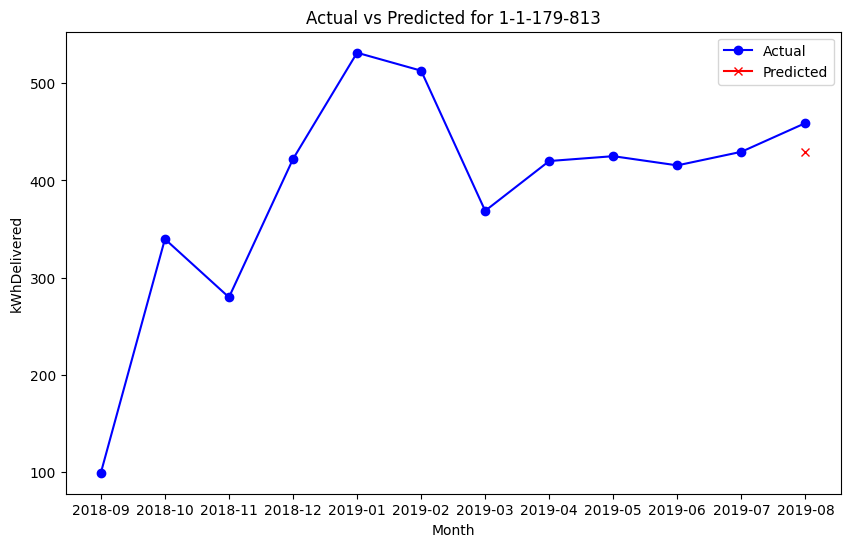

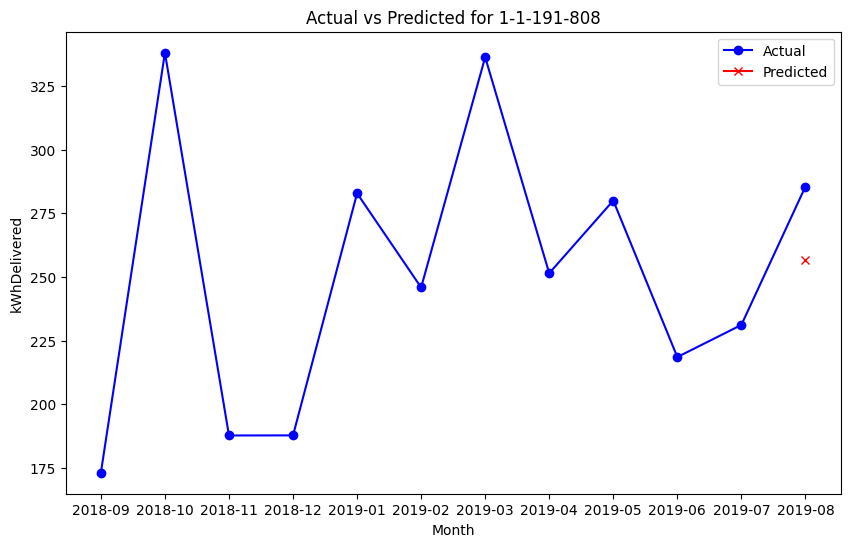

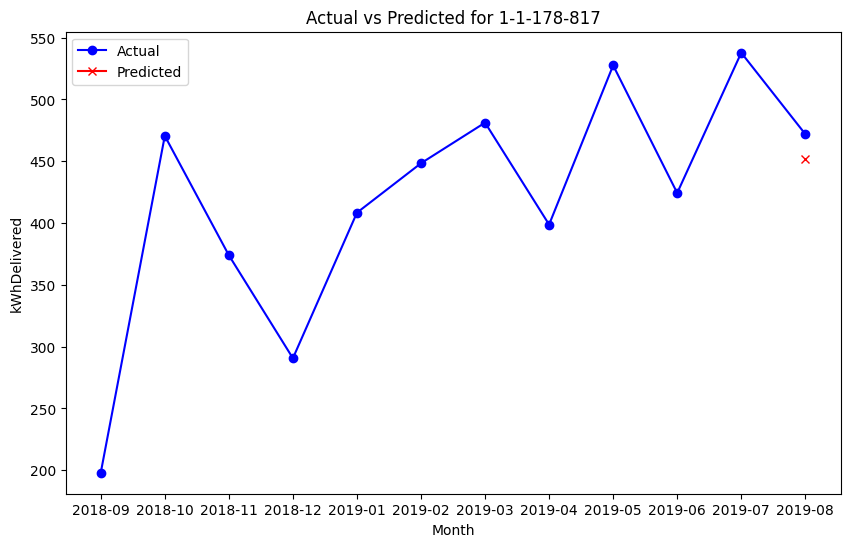

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


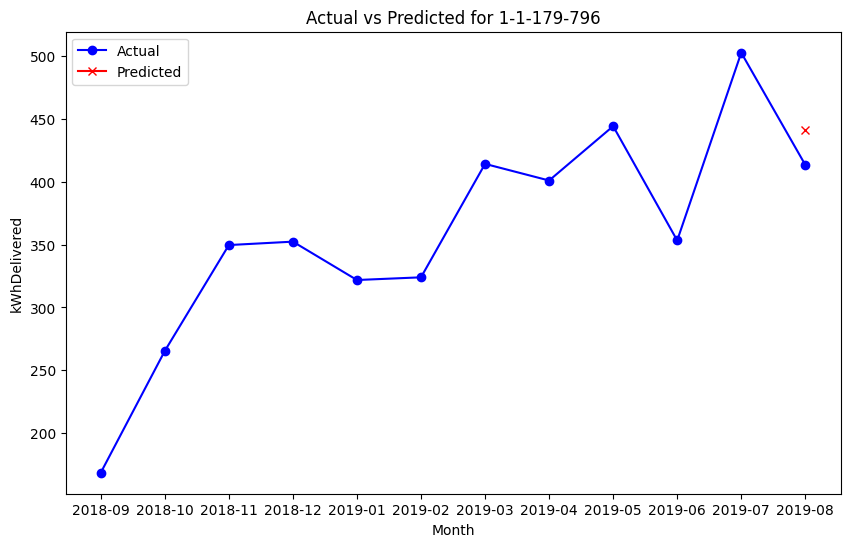

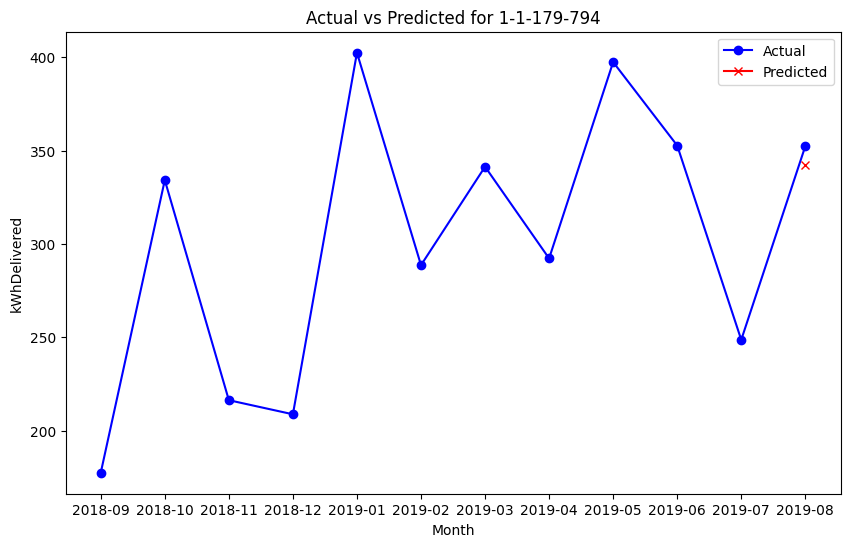

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


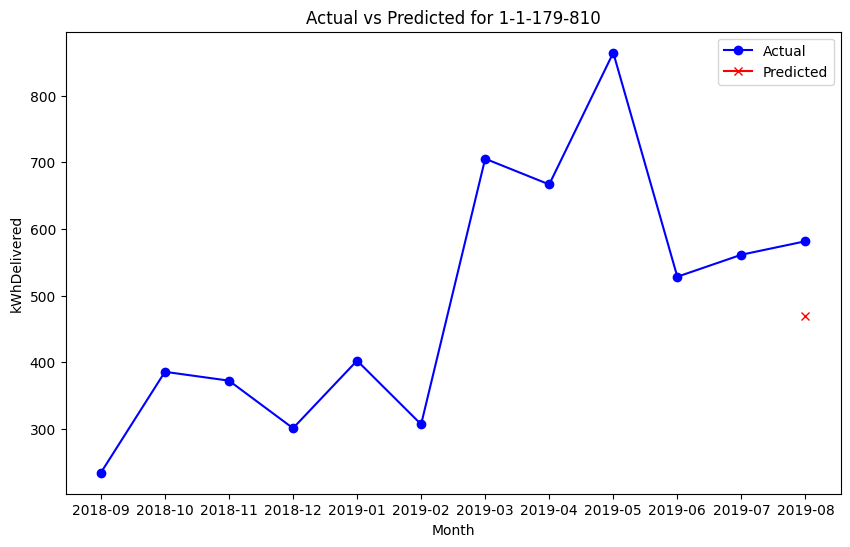

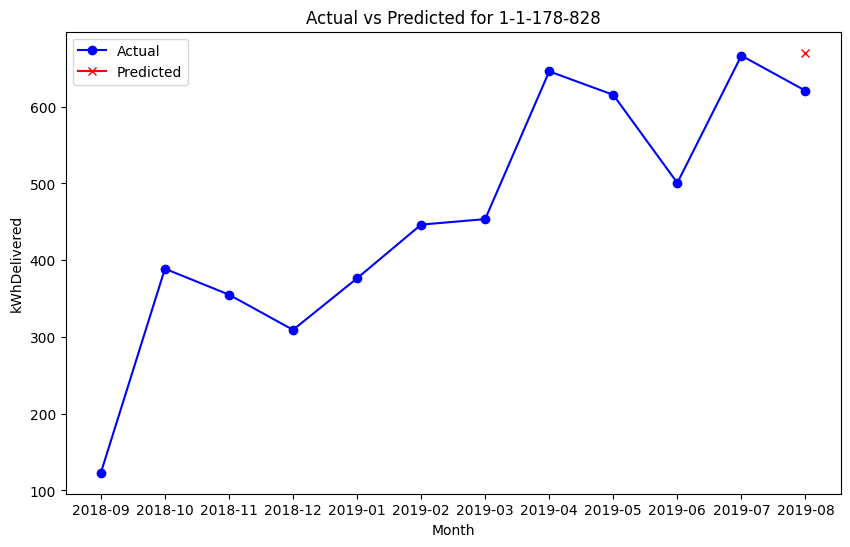

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


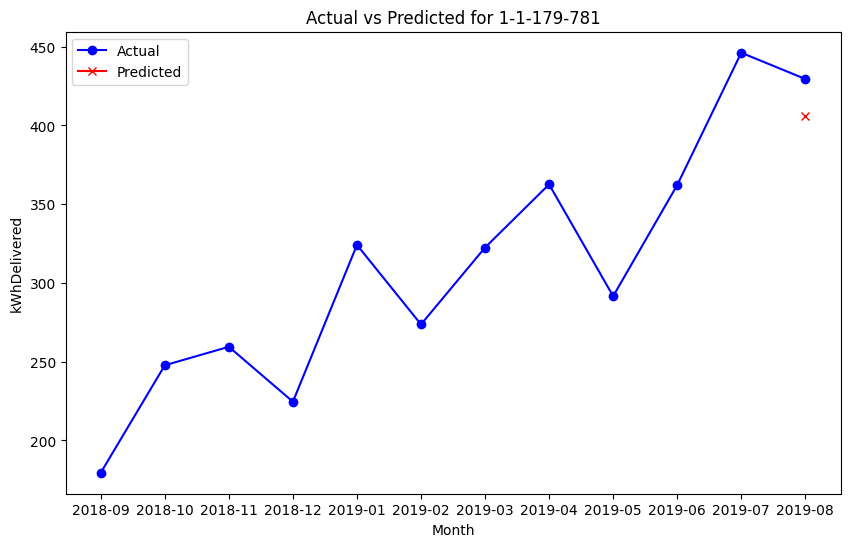

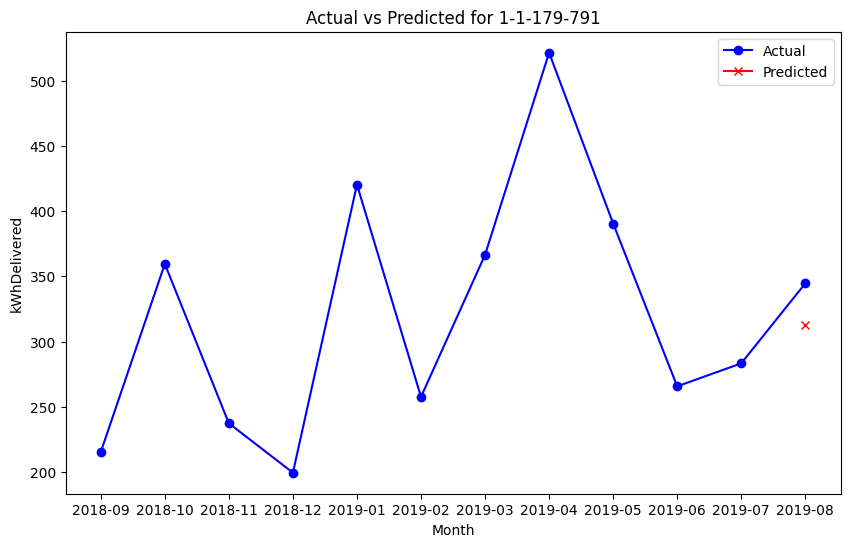

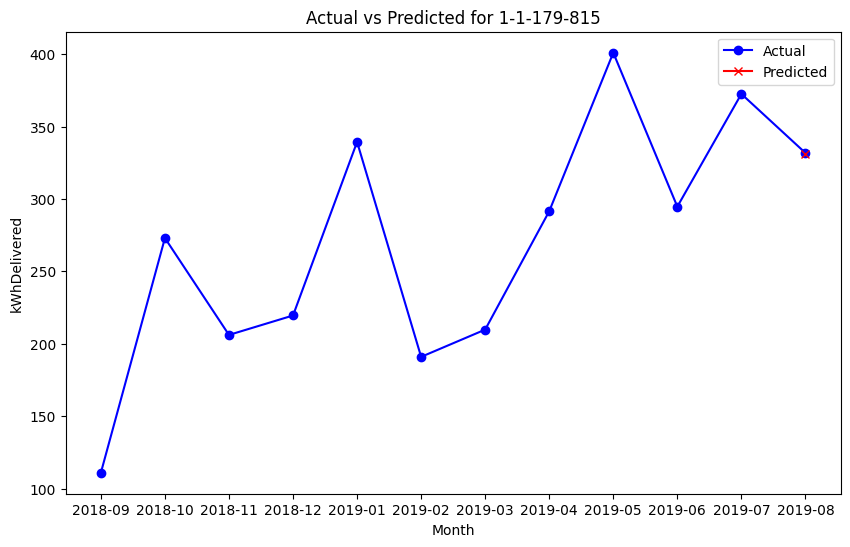

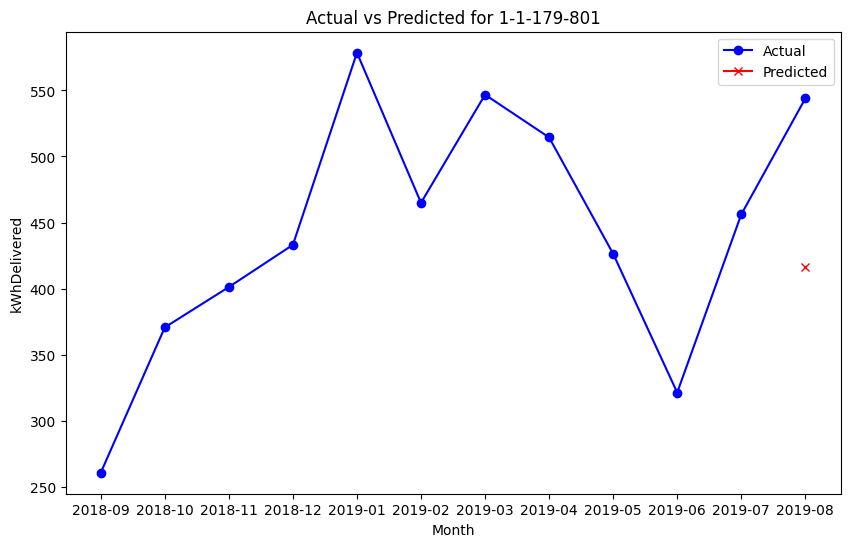

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


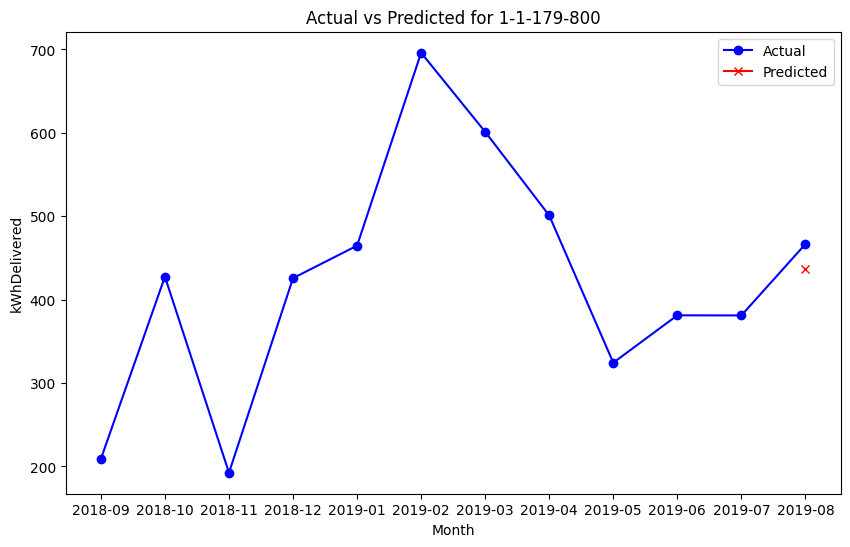

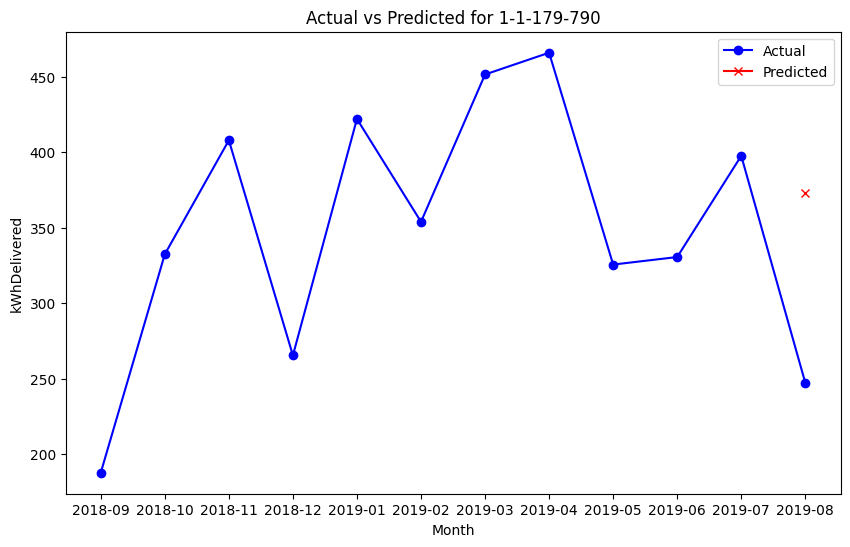

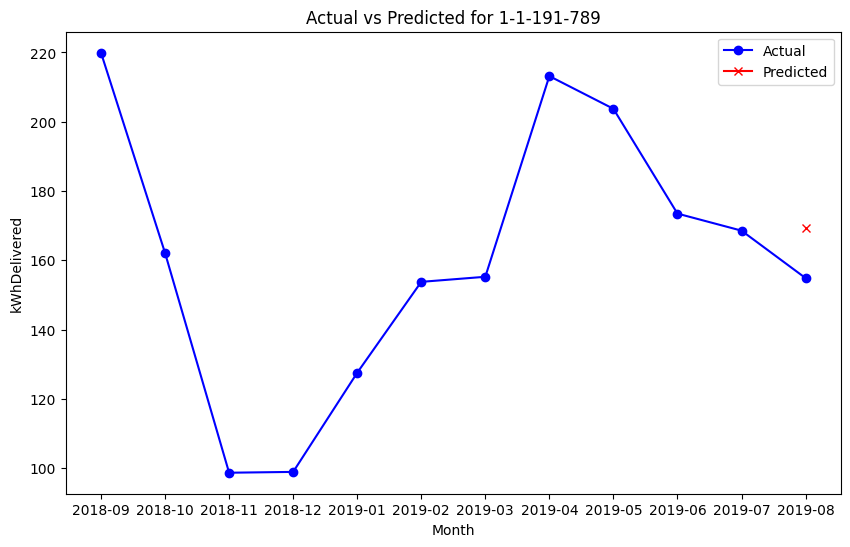

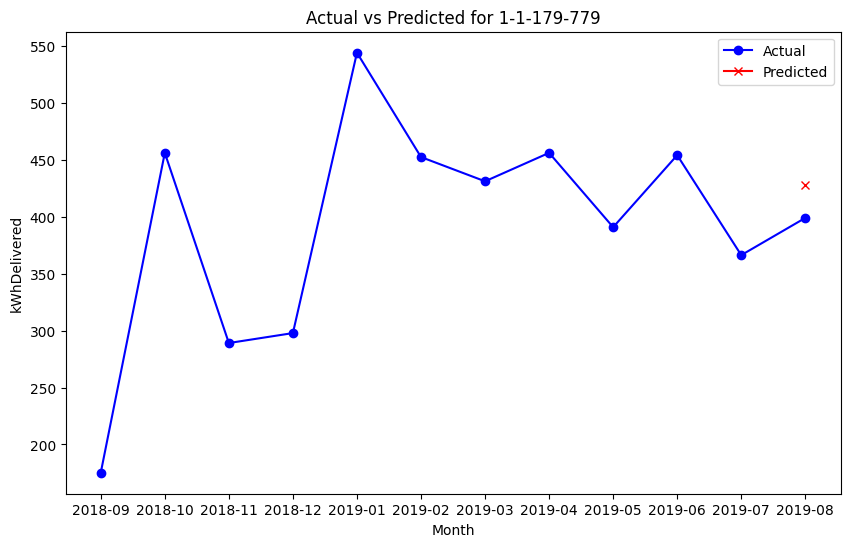

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


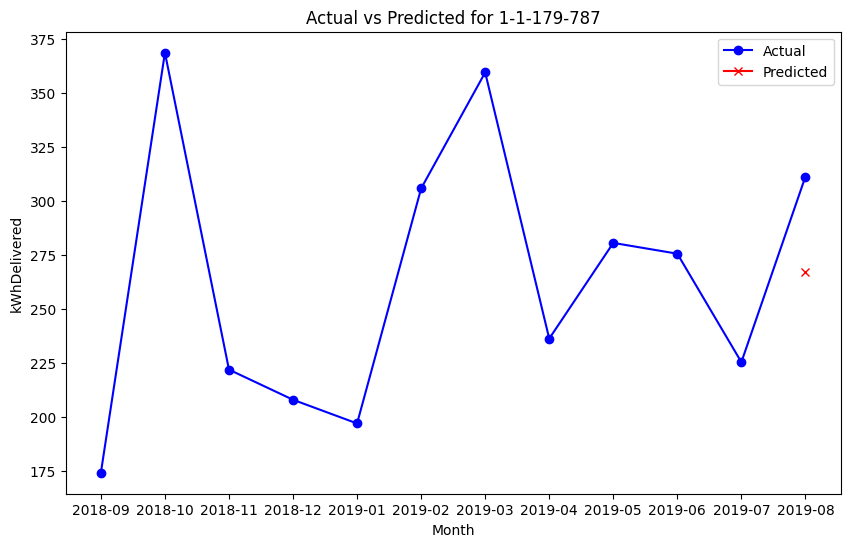

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


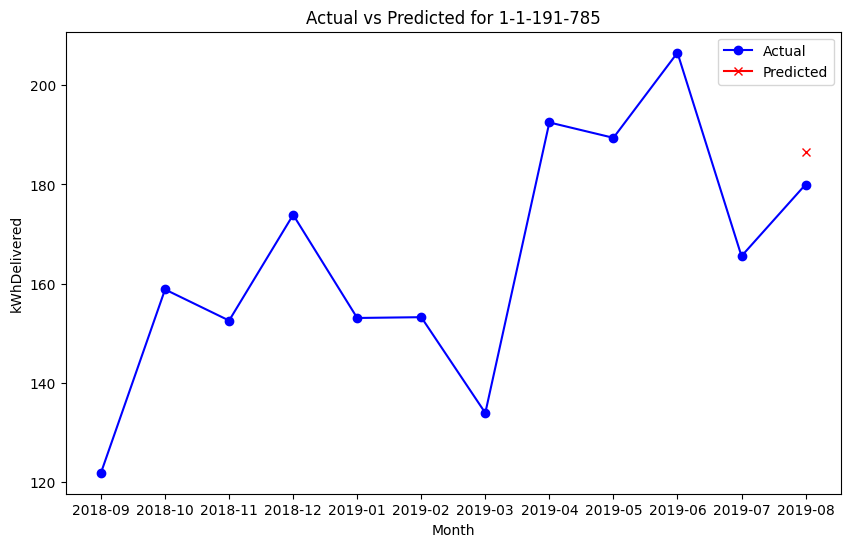

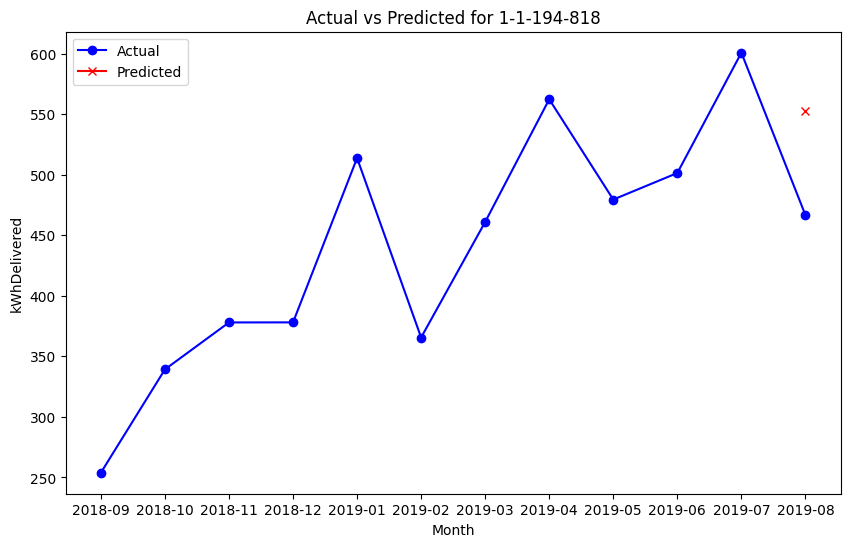

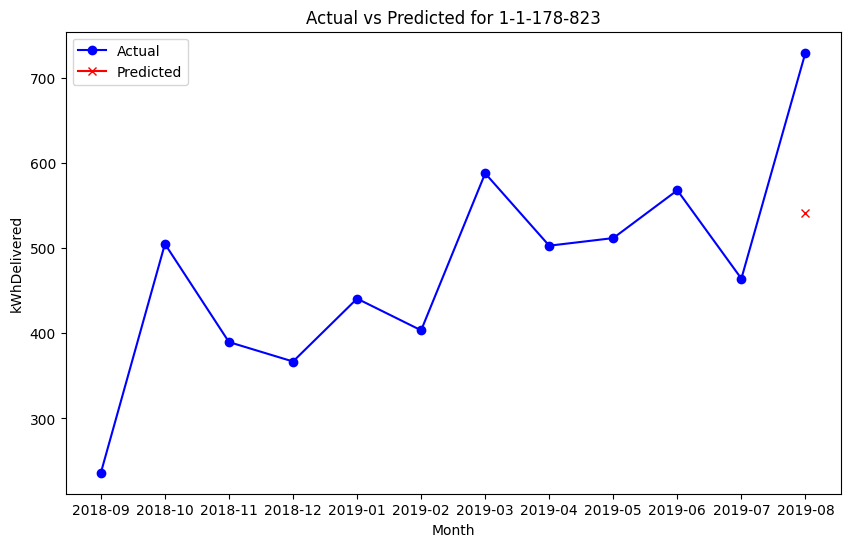

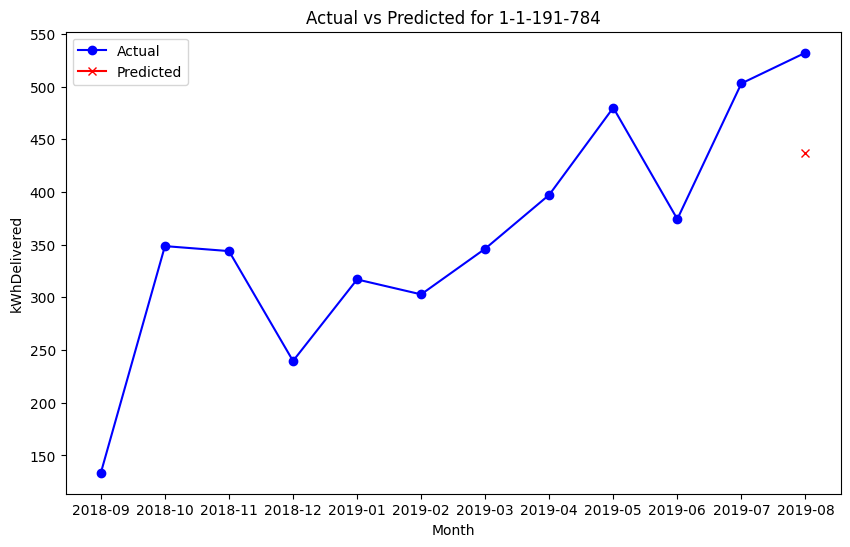

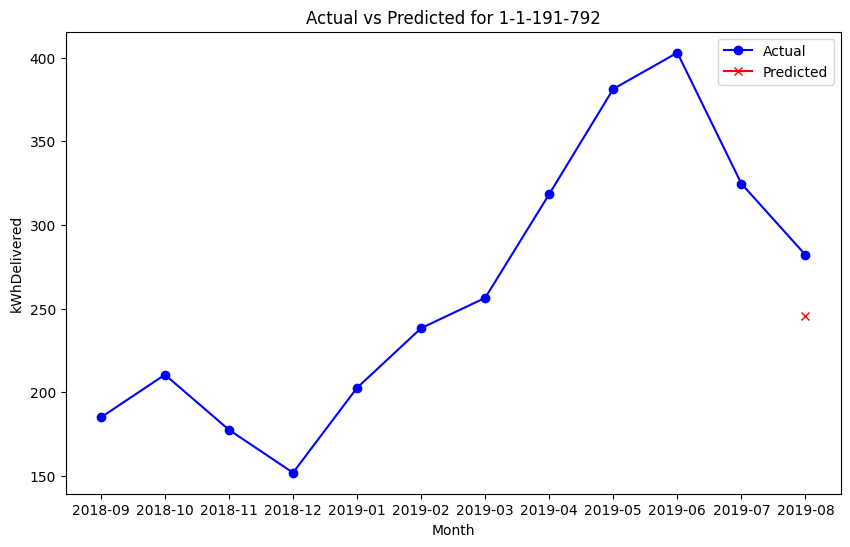

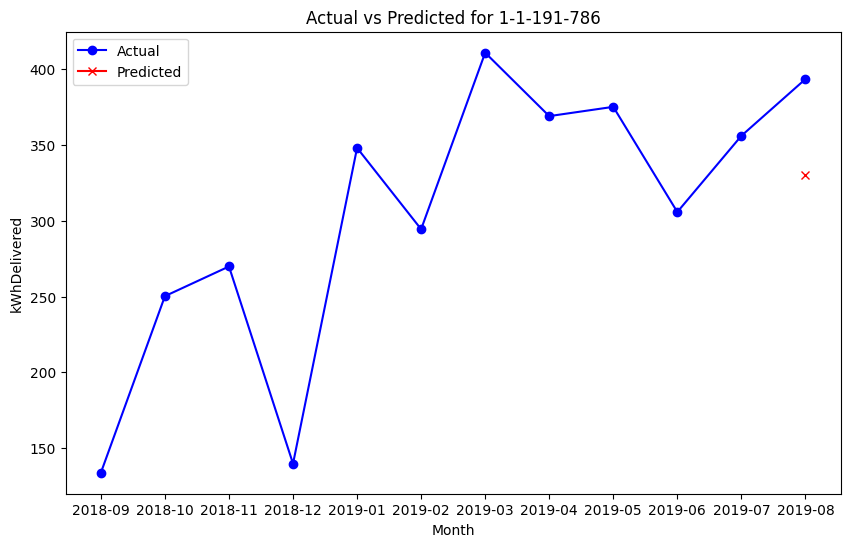

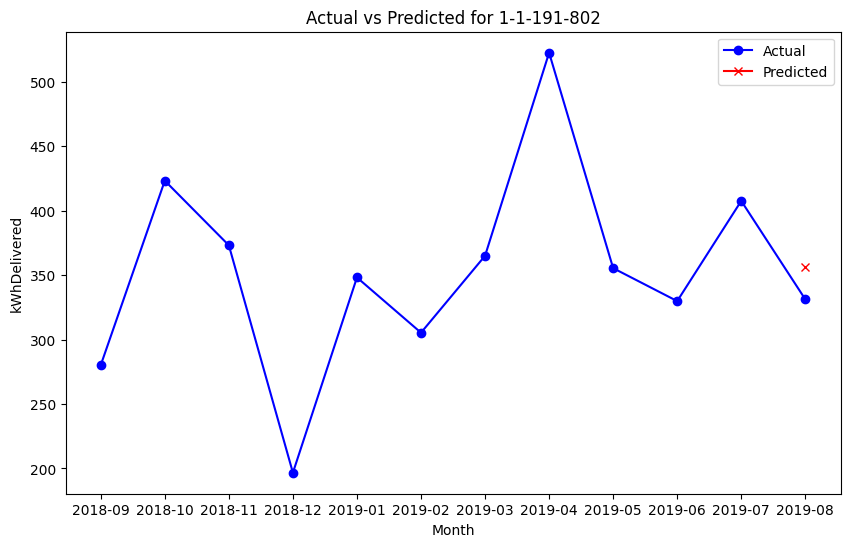

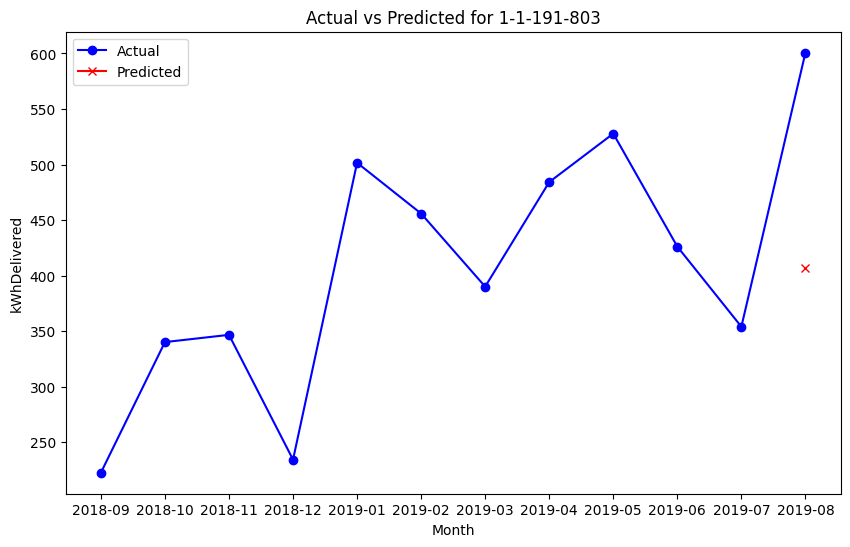

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


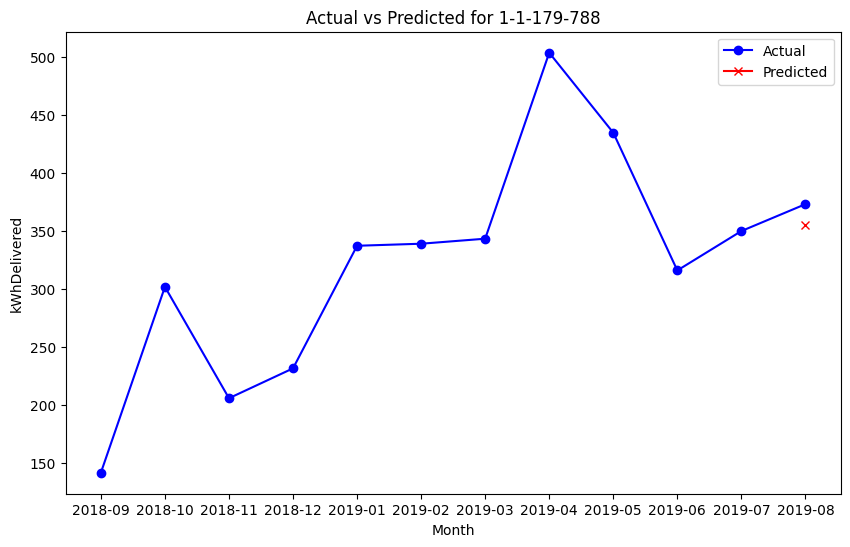

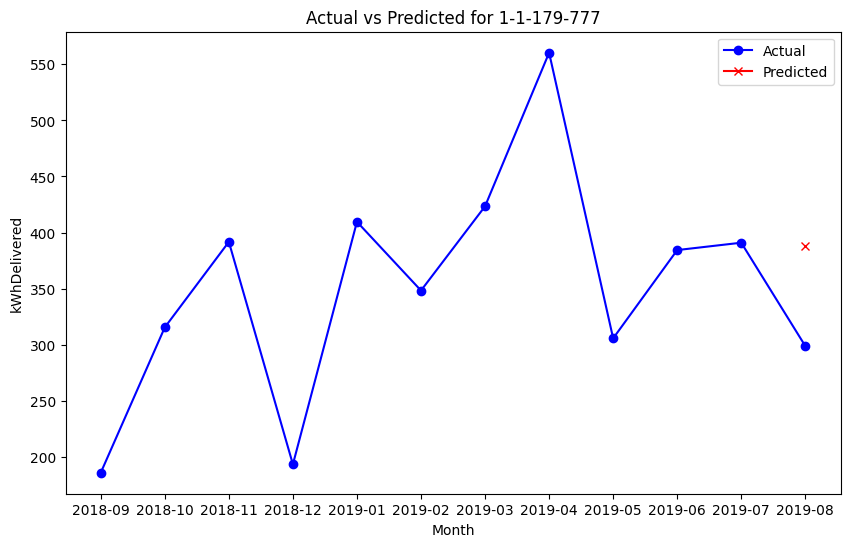

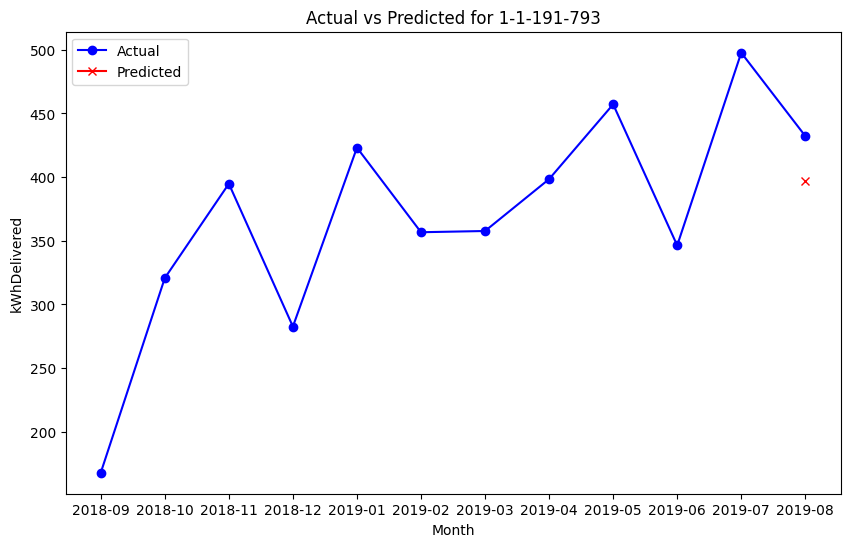

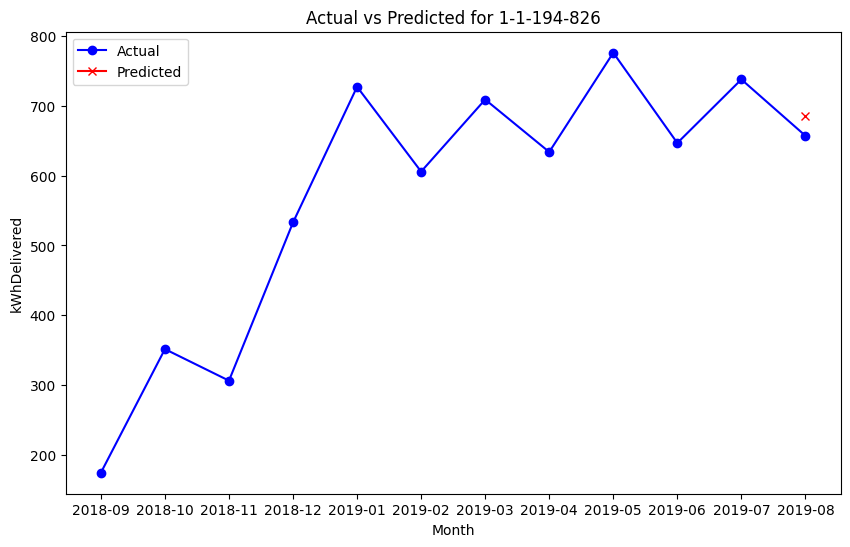

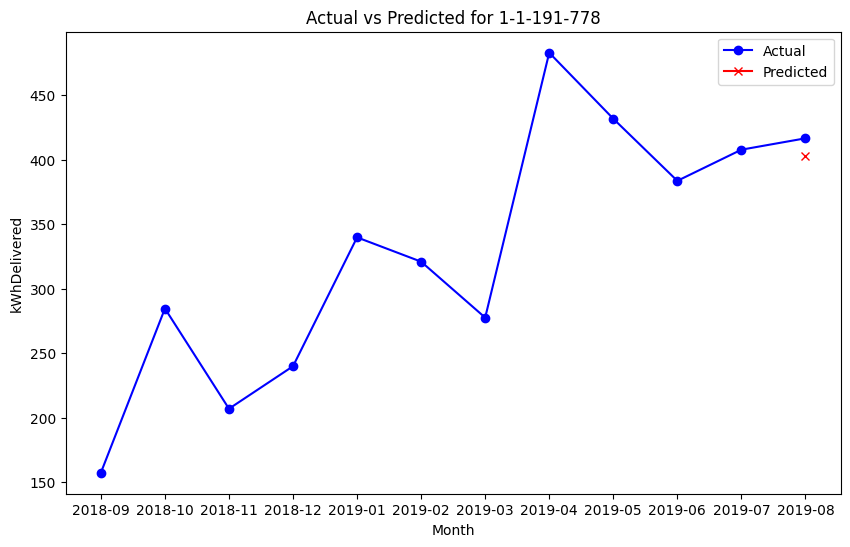

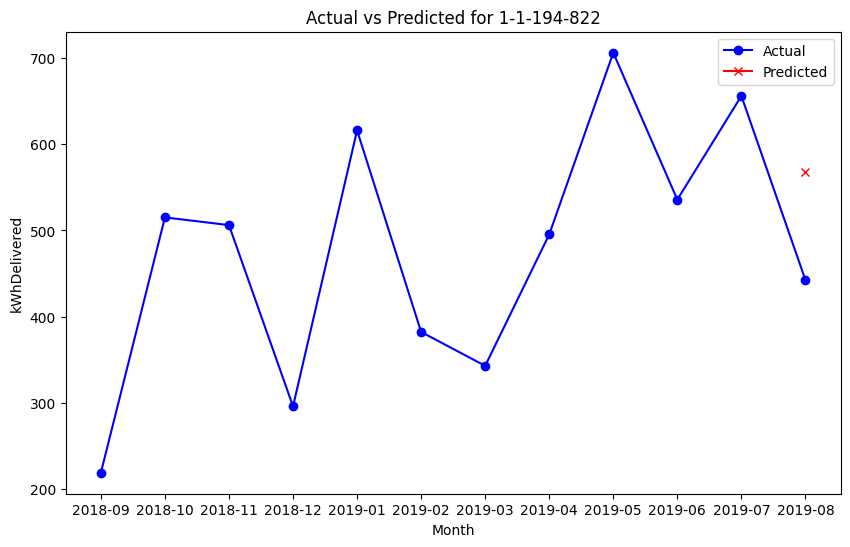

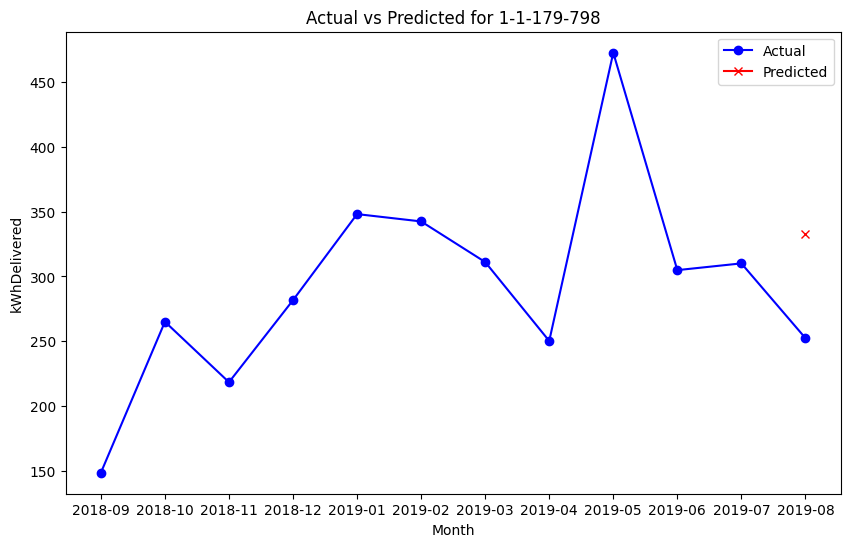

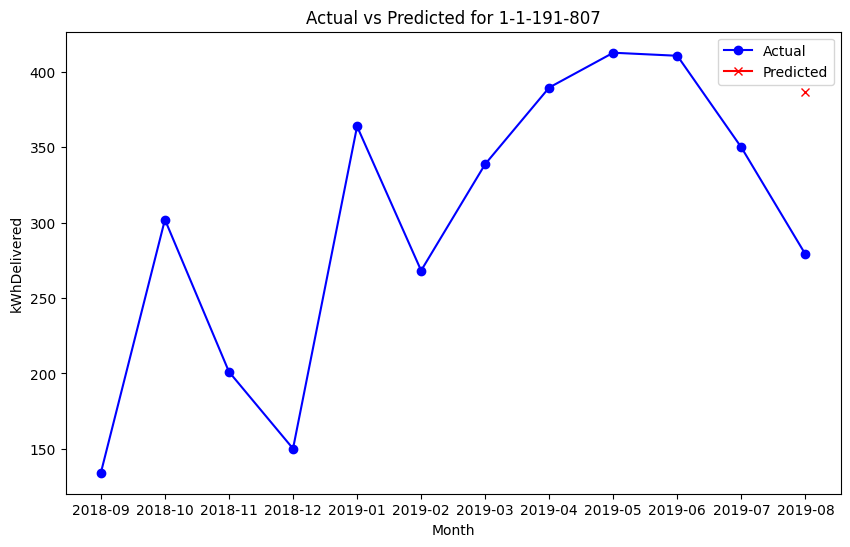

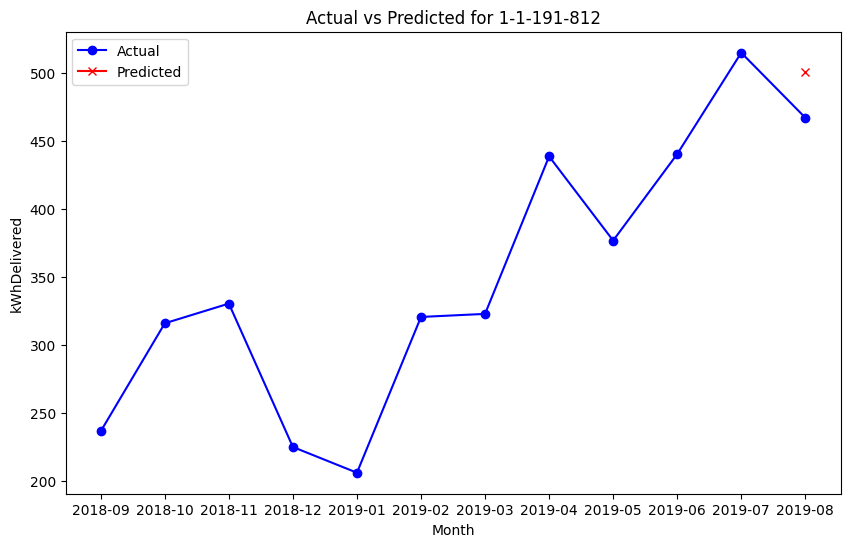

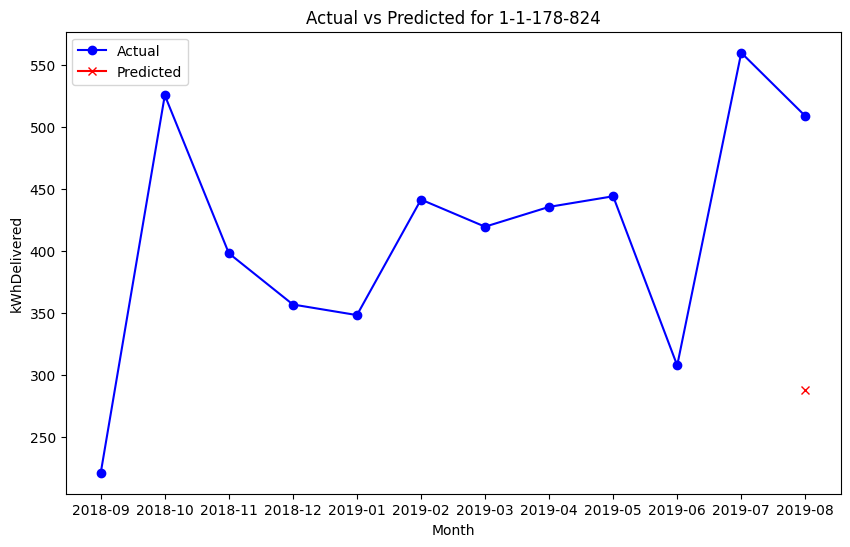

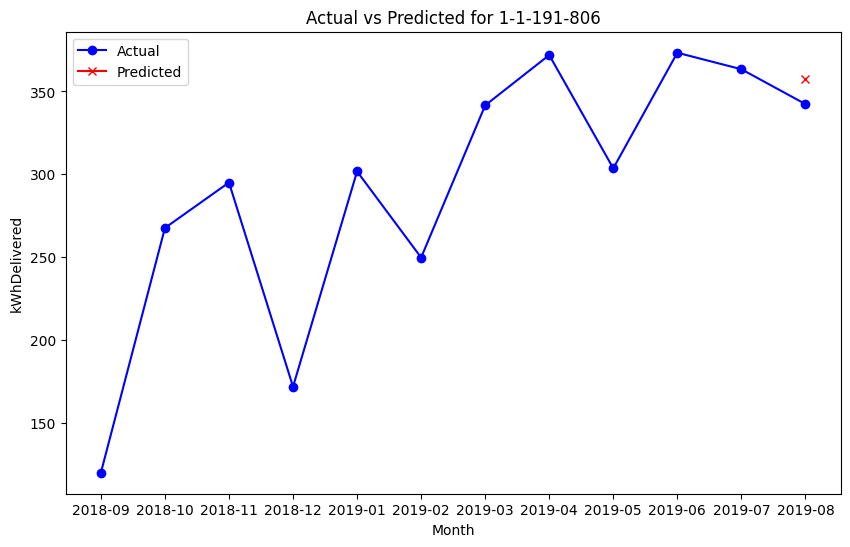

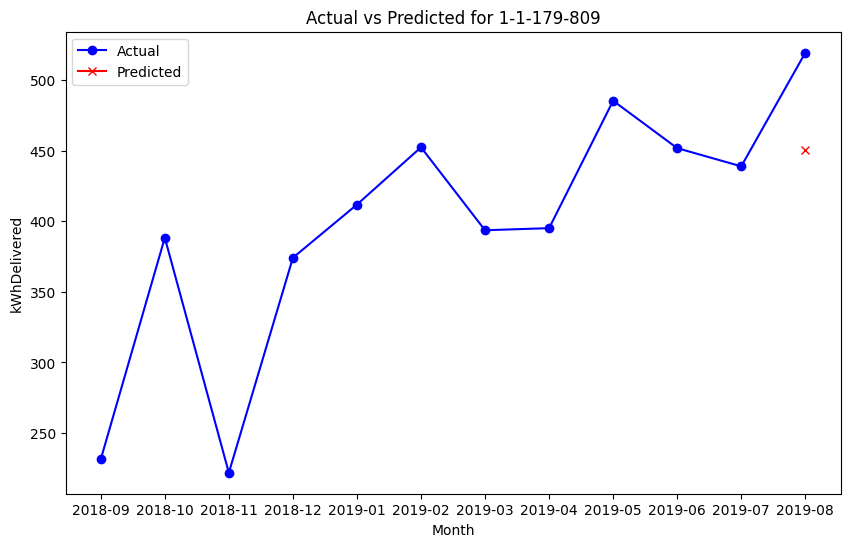

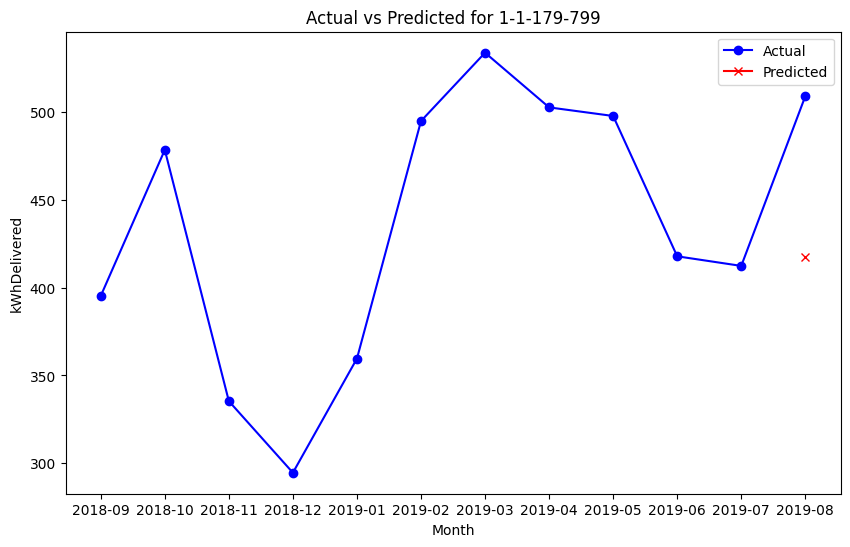

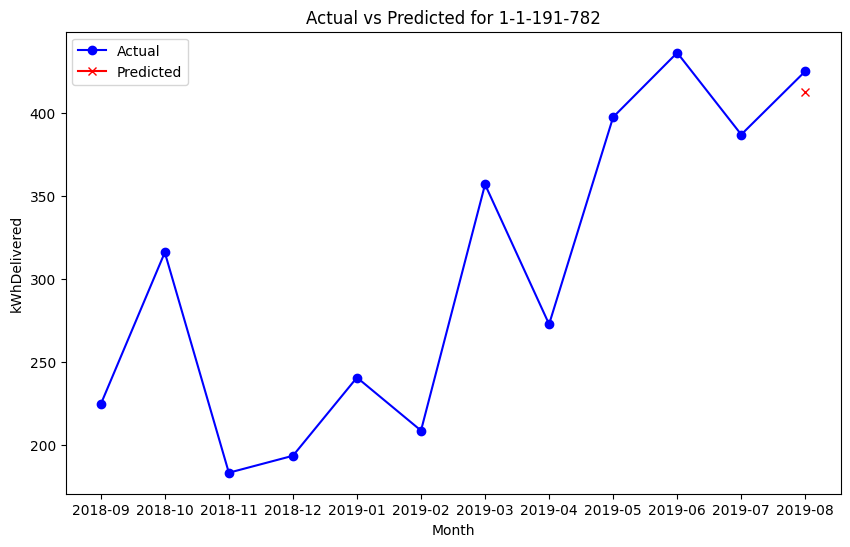

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


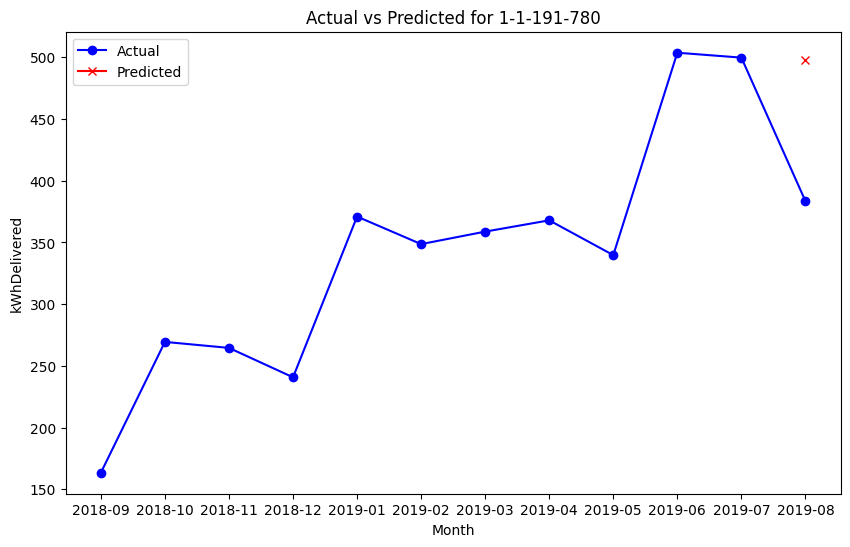

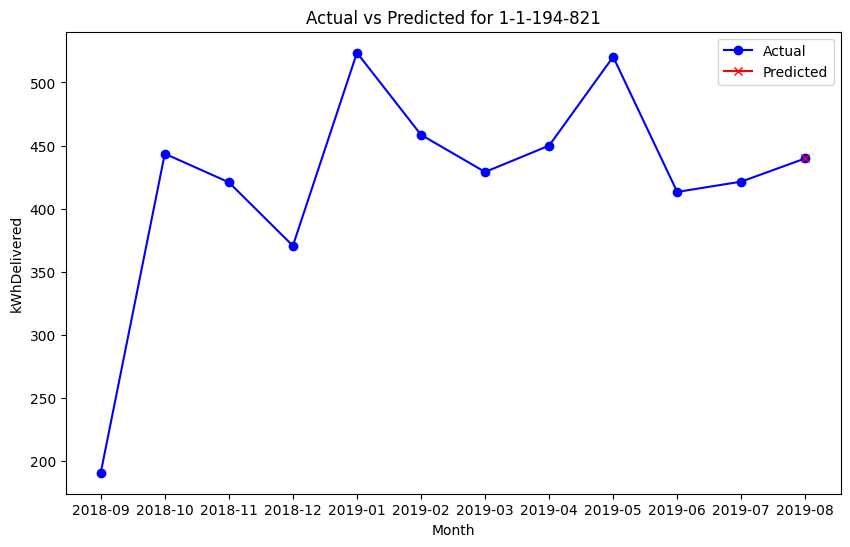

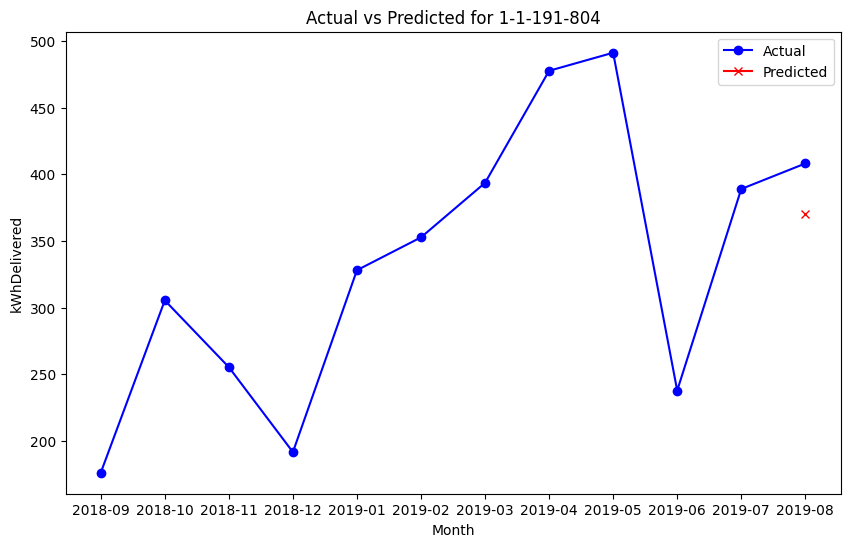

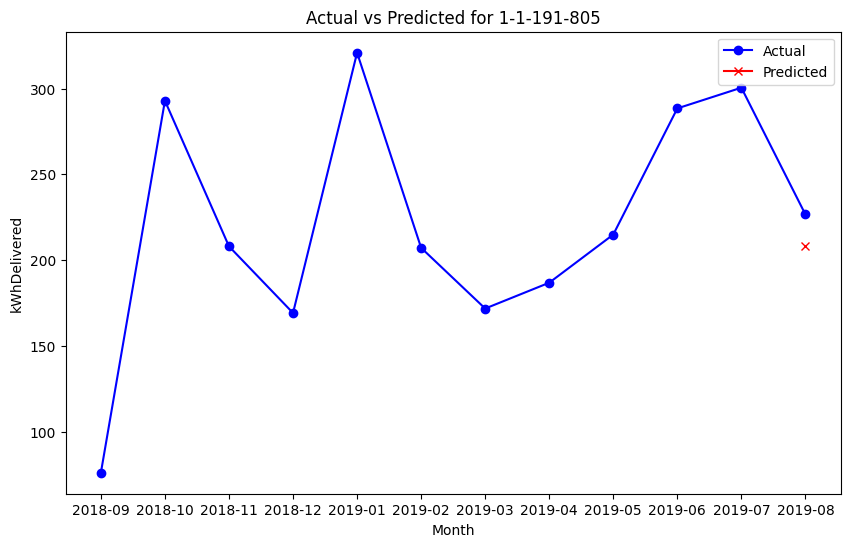

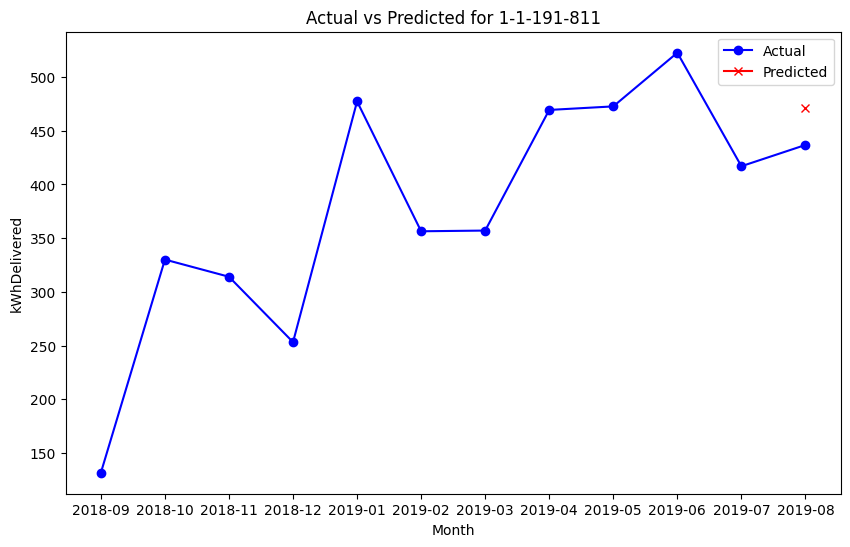

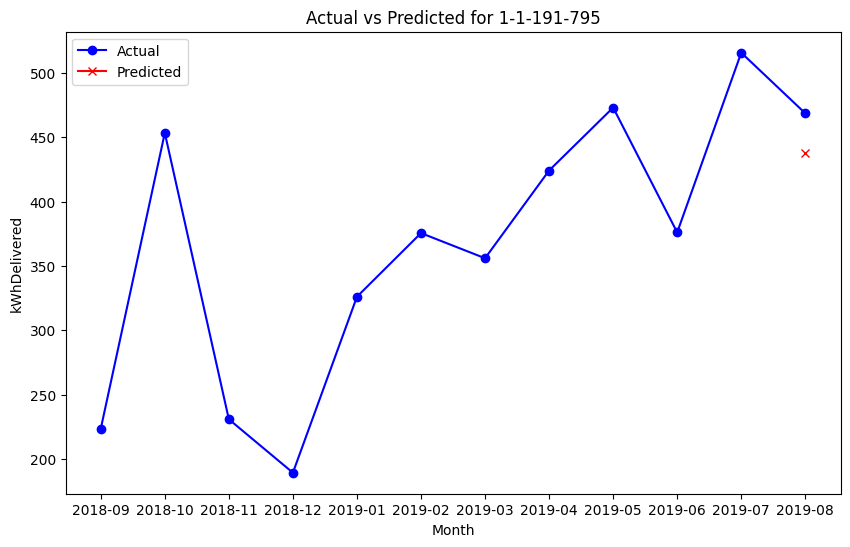

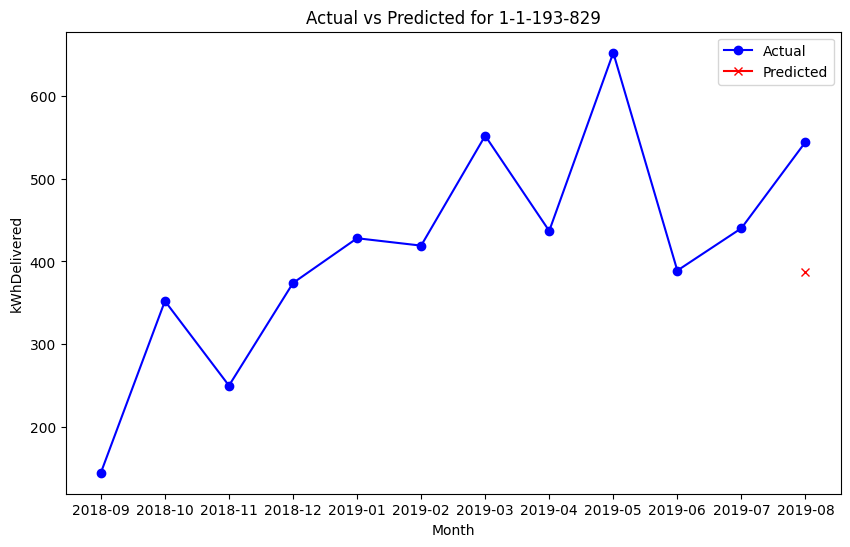

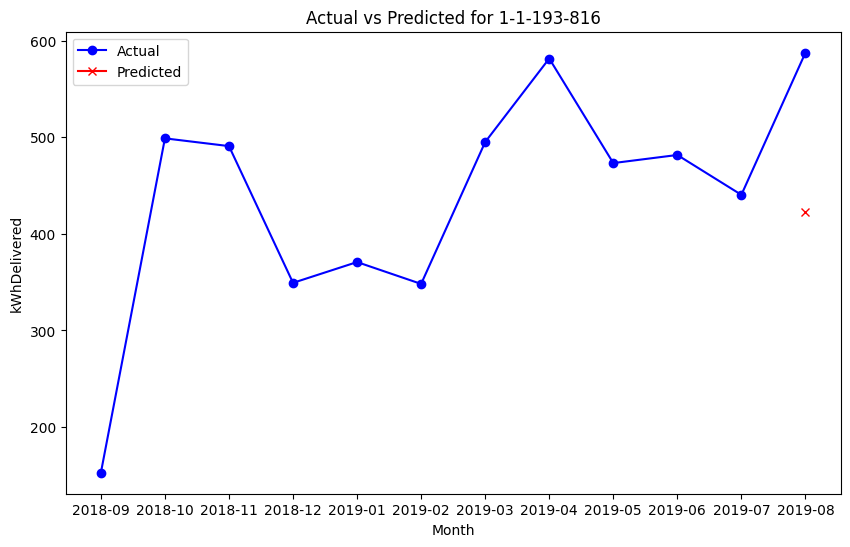

In [83]:
# Initialize a dictionary to store the models and metrics
models = {}
metrics = {}

# Placeholder to store the first trained model for Transfer Learning
previous_model = None
previous_order = ARIMA_ORDER

# List all files in the directory and reverse the order
filenames = sorted([filename for filename in os.listdir(directory) if filename.endswith('.csv')])

# Initialize dictionaries to store models and metrics
models = {}
metrics = {}

# Placeholder for the previous order
previous_order = ARIMA_ORDER

# Read and combine all data files
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        # Load the data from the CSV file
        data = pd.read_csv(filepath)
        
        # Extract the stationID
        stationID = filename.split('.')[0]
        
        # Sort the data by the 'Month' column
        data = data.sort_values(by='month')
        
        # Extract the kWhDelivered series and month
        kWhDelivered = data['kWhDelivered']
        months = data['month']
        
        # Use the previous order for transfer learning or start fresh
        order = previous_order

        # Split data into training and test sets
        train_data = kWhDelivered[:-1]
        test_data = kWhDelivered[-1:]

        # Train the ARIMA model
        model = ARIMA(train_data, order=order).fit()

        # Forecast the next month's kWhDelivered
        forecast = model.forecast(steps=1)
        
        # Calculate metrics
        mae = mean_absolute_error(test_data, forecast)
        mse = mean_squared_error(test_data, forecast)
        smape_value = smape(test_data, forecast)

        # Store the model and metrics
        models[stationID] = model
        metrics[stationID] = {'MAE': mae, 'MSE': mse, 'SMAPE (%)': smape_value}

        # Update the previous_order based on the performance (for example, based on MAE or other criteria)
        # Here we're using a simple placeholder; in practice, you might adjust this based on more complex rules
        previous_order = order  # Placeholder for dynamic adjustment based on performance

        # Plot Actual vs Predicted
        plt.figure(figsize=(10, 6))
        plt.plot(months, kWhDelivered, label='Actual', marker='o', color='b')
        plt.plot(months.iloc[-1:], forecast, label='Predicted', marker='x', color='red')
        plt.title(f'Actual vs Predicted for {stationID}')
        plt.xlabel('Month')
        plt.ylabel('kWhDelivered')
        plt.legend()
        plt.show()

### Results from Transfer Learning

In [84]:
metrics_df = pd.DataFrame.from_dict(metrics, orient='index').reset_index()

# Rename the index column to 'stationID'
metrics_df = metrics_df.rename(columns={'index': 'stationID'})

metrics_df

,stationID,MAE,MSE,SMAPE (%)
0,1-1-193-827,52.830242,2791.034473,14.969133
1,1-1-193-825,1.130785,1.278675,0.256077
2,1-1-193-819,19.100344,364.823158,3.696664
3,1-1-193-820,16.737337,280.138446,4.474402
4,1-1-179-797,117.796577,13876.033601,56.660949
5,1-1-179-783,27.190180,739.305872,9.840857
6,1-1-179-813,29.372878,862.765990,6.611499
7,1-1-191-808,28.898381,835.116396,10.661210
8,1-1-178-817,20.263615,410.614082,4.387676
9,1-1-179-796,28.153113,792.597764,6.584052
